# English to French using Neural Machine Translation

This example was taken from the wonderful Cutting Edge Deep Learning for Coders course as taught by Jeremy Howard http://course.fast.ai/part2.html The course is now live and I encourage you to check it out.

In [1]:
%matplotlib inline
import importlib
#import sutils; importlib.reload(sutils)
from sutils import *

import keras
import gensim
import re
import pickle
import keras.backend as K

from keras import initializers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.callbacks import LambdaCallback


from recurrentshop import *
import seq2seq
from seq2seq.models import AttentionSeq2Seq,SimpleSeq2Seq, Seq2Seq

import tensorflow as tf

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.4
1.1.0


In [3]:
from gensim.models import word2vec

In [4]:
limit_gpu_mem()

In [5]:
path='/home/samwit/ai_data_local/neural_translation/'
dpath = '/home/samwit/ai_data_local/neural_translation/translate/'

### Set up Regex and tokenize for use later

In [6]:
re_mult_space = re.compile(r"  *")
re_mw_punc = re.compile(r"(\w[’'])(\w)")
re_punc = re.compile("([\"().,;:/_?!—])")
re_apos = re.compile(r"(\w)'s\b")


def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

## Load the PreProcessed data

Here we load all the data 

In [7]:
data = load(dpath+'nmt_data.pkl')
look_ups = load(dpath+'look_ups.pkl')
fr_train = data['fr_train']
fr_test = data['fr_test']
en_train = data['en_train']
en_test = data['en_test']
en_w2id = look_ups['en_w2id']
fr_vocab = look_ups['fr_vocab']
en_vocab = look_ups['en_vocab']
en_embs = look_ups['en_embs']
fr_embs = look_ups['fr_embs']

questions = load(dpath+'questions.pkl')
print(questions[10])
en_qs, fr_qs = zip(*questions)

('Which province has the highest population density?', 'Quelle est la province ayant la plus forte densité de population ?')


In [8]:
# for running model test on small set of data
#fr_train = fr_train[:5000]
#en_train = fr_train[:5000]

fr_train.shape

(47097, 30)

In [9]:
en_train.shape

(47097, 30)

## Model

#### Create some Keras Callbacks to handle early stopping and Learning Rate changes

In [10]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=0,cooldown=1, min_lr = 0.00001)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=4,verbose=0,mode='auto')

import math

# learning rate schedule for dropping every 10 epochs
def LRDropping(epoch):
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# try at manual setting of LR for Epochs
def fixed_dropping(epoch):
    if epoch < 2: 
        lrate = 0.01
    elif epoch < 4: 
        lrate = 0.001
    elif epoch < 7: 
        lrate = 0.0005
    else:
        lrate = 0.0001
    print(lrate)
    return lrate

LRDrop = LearningRateScheduler(fixed_dropping)

In [11]:
# creating different sets of Params to easily import into the model at train time
params = {'verbose': 1, 'callbacks': [TQDMNotebookCallback(),reduce_LR,early_stopping]}
params2 = {'verbose': 1, 'callbacks': [LRDrop,TQDMNotebookCallback(),reduce_LR,early_stopping]}
params3 = {'verbose': 1, 'callbacks': [LRDrop,TQDMNotebookCallback(),reduce_LR,early_stopping]}

#### Set some parameters for the model

In [12]:
lr = 1e-3
maxlen = 30
dim_en_vec = 100
n_en_vec = 400000
dim_fr_vec = 200

vocab_size = len(fr_vocab) #the output vocab # embeddings.shape[0]
embedding_size = 100 #The english inputs embeddings embeddings.shape[1]

In [13]:
fr_wgts = [fr_embs.T, np.zeros((len(fr_vocab,)))]


2

### The model itself

In [26]:
inp = Input((maxlen,))
x = Embedding(len(en_vocab), dim_en_vec, input_length=maxlen,
              weights=[en_embs], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(dim_fr_vec))(x)
x = TimeDistributed(Dense(len(fr_vocab), weights=fr_wgts))(x)
x = Activation('softmax')(x)

In [27]:
model = Model(inp, x)
model.compile('adam', 'sparse_categorical_crossentropy')

In [28]:
K.set_value(model.optimizer.lr, lr)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 30, 100)           1954800   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 256)           234496    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 200)           25800     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 26708)         5368308   
__________

In [30]:
hist=model.fit(en_train, np.expand_dims(fr_train,axis=-1), batch_size=64, epochs=20, **params, 
               validation_data=[en_test, np.expand_dims(fr_test,axis=-1)])

Train on 47097 samples, validate on 5234 samples


Epoch 1/20
47097/47097 [==============================] - 118s - loss: 3.5282 - val_loss: 3.3039


Epoch 2/20
47097/47097 [==============================] - 119s - loss: 3.2387 - val_loss: 3.2106


Epoch 3/20
47097/47097 [==============================] - 118s - loss: 3.1271 - val_loss: 3.1143


Epoch 4/20
47097/47097 [==============================] - 118s - loss: 3.0337 - val_loss: 3.0357


Epoch 5/20
47097/47097 [==============================] - 118s - loss: 2.9418 - val_loss: 2.9656


Epoch 6/20
47097/47097 [==============================] - 118s - loss: 2.8551 - val_loss: 2.9036


Epoch 7/20
47097/47097 [==============================] - 118s - loss: 2.7728 - val_loss: 2.8623


Epoch 8/20
47097/47097 [==============================] - 118s - loss: 2.6987 - val_loss: 2.8191


Epoch 9/20
47097/47097 [==============================] - 118s - loss: 2.6337 - val_loss: 2.7830


Epoch 10/20
47097/47097 [==============================] - 118s - loss: 2.5732 - val_loss: 2.7534


Epoch 11/20
47097/47097 [==============================] - 118s - loss: 2.5146 - val_loss: 2.7446


Epoch 12/20
47097/47097 [==============================] - 116s - loss: 2.4604 - val_loss: 2.7271


Epoch 13/20
47097/47097 [==============================] - 116s - loss: 2.4105 - val_loss: 2.7038


Epoch 14/20
47097/47097 [==============================] - 117s - loss: 2.3636 - val_loss: 2.6948


Epoch 15/20
47097/47097 [==============================] - 117s - loss: 2.3190 - val_loss: 2.6913


Epoch 16/20
47097/47097 [==============================] - 117s - loss: 2.2789 - val_loss: 2.6886


Epoch 17/20
47097/47097 [==============================] - 117s - loss: 2.2389 - val_loss: 2.7016


Epoch 18/20
47097/47097 [==============================] - 117s - loss: 2.1539 - val_loss: 2.6846


Epoch 19/20
47097/47097 [==============================] - 117s - loss: 2.1279 - val_loss: 2.6968


Epoch 20/20
47097/47097 [==============================] - 117s - loss: 2.0786 - val_loss: 2.6945



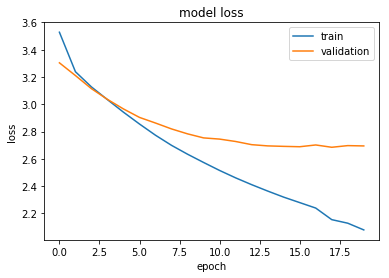

In [43]:
plot_train(hist)

In [44]:
model.save_weights(dpath+'trans_testing_basic2.h5')

In [55]:
model.load_weights(dpath+'trans_testing_basic2.h5')

## Testing

In [46]:
def sent2ids(sent):
    sent = simple_toks(sent)
    ids = [en_w2id[t] for t in sent]
    return pad_sequences([ids], maxlen, padding="post", truncating="post")

In [47]:
def en2fr(sent): 
    ids = sent2ids(sent)
    tr_ids = np.argmax(model.predict(ids), axis=-1)
    return ' '.join(fr_vocab[i] for i in tr_ids[0] if i>0)

In [48]:
en2fr("what is the size of canada?")


'quelle est la taille de canada ?'

In [59]:
en2fr("what is the size of australia?")


'quelle est la taille de canada ?'

In [49]:

print(fr_qs[0])
en2fr("What is light?")

Qu’est-ce que la lumière?


"qu' est ce que la ? ?"

In [50]:
print(qs[50000])
en2fr("Why is the Arctic ozone layer thicker than the Antarctic ozone layer?")


('Why is the Arctic ozone layer thicker than the Antarctic ozone layer?', "Pourquoi la couche d'ozone arctique est-elle plus épaisse que celle située au-dessus de l'Antarctique?")


'pourquoi le couche de couche ozone ozone ozone il épaisse épaisse le la ozone ozone ozone ozone ?'

In [51]:
print(qs[9])
en2fr("Which province is the most populated?")

('Which province is the most populated?', 'Quelle est la province la plus peuplée ?')


'quelle province province le plus plus peuplée plus ?'

In [52]:
en2fr("Who are we?")

'qui fait nous ?'

In [53]:
print(qs[3])
en2fr("What would we do without it?")

('What would we do without it?', 'Que ferions-nous sans elle ?')


'que ferions nous faire ? ?'